In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on the sonar dataset with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import time

In [33]:
heart = pd.read_csv('dataset/heart.csv')
#heart2 = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')

In [34]:
dataset = heart

In [35]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [36]:
dataset = pd.get_dummies(dataset ,drop_first=True)

In [37]:
categorical_cols = dataset[['sex','exng','caa','cp','fbs','restecg','slp','thall']]
numerical_cols = dataset[["age","trtbps","chol","thalachh","oldpeak"]]
target_col = dataset[["output"]]

In [38]:
from scipy import stats
# calculating zscore of numeric columns in the dataset
z = np.abs(stats.zscore(numerical_cols))
print(z)

[[0.94979429 0.76406571 0.26128493 0.01882584 1.08402203]
 [1.92854796 0.09140084 0.06774054 1.63697881 2.11892611]
 [1.48572607 0.09140084 0.82256367 0.98097085 0.30784398]
 ...
 [1.50332164 0.70703461 1.0354625  0.37477894 2.0326841 ]
 [0.28556146 0.09140084 2.23543773 1.51185941 0.13535997]
 [0.28556146 0.09140084 0.20322161 1.06843858 0.8995441 ]]


In [39]:
# Defining threshold for filtering outliers 
threshold = 3
print(np.where(z > 3))

(array([ 28,  85, 203, 219, 220, 222, 245, 247, 271], dtype=int64), array([2, 2, 4, 2, 4, 1, 2, 1, 3], dtype=int64))


In [40]:
#filtering outliers retaining only those data points which are below threshhold
#dataset = dataset[(z < 3).all(axis=1)]


In [41]:
dataset

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
297   57    0   0     140   241    0        1       123     1      0.2    1   
298   45    1   3     110   264    0        1       132     0      1.2    1   
299   68    1   0     144   193    1        1       141     0      3.4    1   
300   57    1   0     130   131    0        1       115     1      1.2    1   
301   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  
1      0      2       1  
2      0      2       1  
3      0      2       1  
4      0      2       1  
..   ...    ...     ...  
297    0      3       0  
298    0      3       0  
299    2      3       0  
300    1      3       0  
301    1      2       0  

[302 rows x 14 columns]

In [42]:
len(dataset)

302

In [43]:
X = dataset.iloc[:, 0:-1].values

y = dataset.iloc[:, -1].values

In [19]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

## Train the LG Classifier

In [20]:
def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    cpu_10 = []
    roc_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        cpu = []
        roc_list = []
        



        for train_ix, test_ix in kfold.split(X, y):




            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            
            t0= time.time()
            if (param == 0):
                model = LogisticRegression()
                
            else:
                model = LogisticRegression(C=param['C'], penalty = param['penalty'])

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            probs = model.predict_proba(X_test)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        #print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)

    plt.figure(figsize=(10,6))
    plt.plot(range(0,30),accuracy_10,color='blue', linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('checking the variance in 30 iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    return([accu,pre,spec,rec,f1,roc,cpu])



## Grid serach 

In [21]:
from sklearn.model_selection import GridSearchCV
def grid_search():
    
    logreg =LogisticRegression()
    grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

    grid = GridSearchCV(logreg,param_grid=grid_values )
    grid.fit(X_train,y_train)
    grid.best_params_
    return(grid.best_params_)


In [65]:
dict_LG = {}

## First Model without preprocessing 

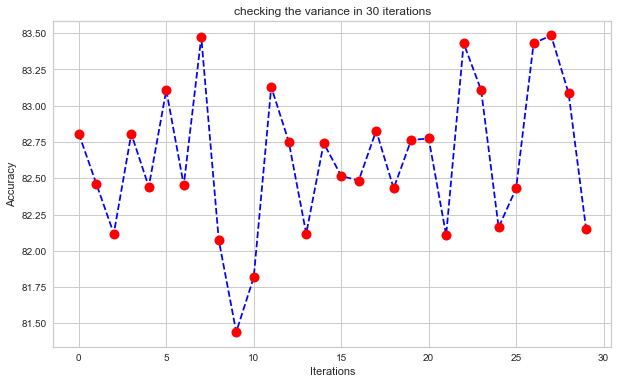

{'LG': [82.63082437275985,
  83.7708074631974,
  81.26438186849917,
  82.63082437275985,
  82.44399497049089,
  90.17732154344634,
  0.0022128009796142578]}

In [43]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
    
dict_LG['LG'] = result
dict_LG


## Hypertune model using grid search

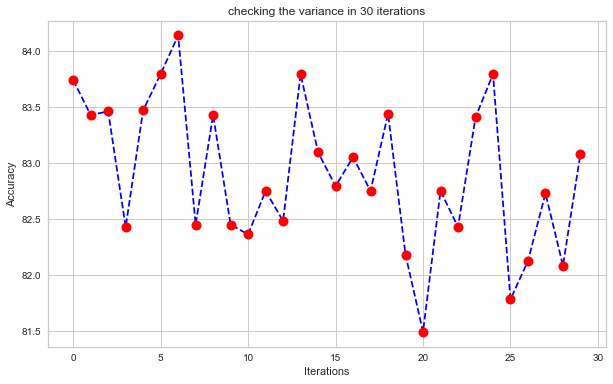

{'LG': [82.63082437275985,
  83.7708074631974,
  81.26438186849917,
  82.63082437275985,
  82.44399497049089,
  90.17732154344634,
  0.0022128009796142578],
 'Hypertuned': [82.90752688172043,
  84.2814171324002,
  80.93301422788635,
  82.90752688172043,
  82.68798169042311,
  90.70146389916543,
  0.0017877801259358727]}

In [44]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_LG['Hypertuned'] = result
dict_LG

## PCA

In [45]:
from sklearn.decomposition import PCA
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
pca = PCA(n_components = 4)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)

In [46]:
pca.explained_variance_ratio_

array([0.21313479, 0.11859478, 0.09359819, 0.09121102])

In [47]:
df_comp = pd.DataFrame(pca.components_,columns=dataset.iloc[:, 0:-1].columns)

In [48]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

<AxesSubplot:>

In [49]:
X = x_pca
y = dataset.iloc[:, -1].values
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=101)
param = grid_search()
print(param)
result = calculate_model(param,X,y)
dict_LG['Pca'] = result
dict_LG

{'C': 10, 'penalty': 'l2'}


{'LG': [82.63082437275985,
  83.7708074631974,
  81.26438186849917,
  82.63082437275985,
  82.44399497049089,
  90.17732154344634,
  0.0022128009796142578],
 'Hypertuned': [82.90752688172043,
  84.2814171324002,
  80.93301422788635,
  82.90752688172043,
  82.68798169042311,
  90.70146389916543,
  0.0017877801259358727],
 'Pca': [83.34874551971329,
  84.49228597468674,
  82.48641889293559,
  83.34874551971329,
  83.24924577103879,
  91.1678835350506,
  0.0013912375768025717]}

## Feature Importance

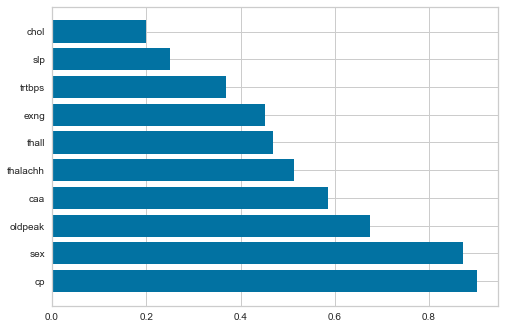

In [50]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
features_names = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh','exng', 'oldpeak', 'slp', 'caa', 'thall']
svm = LogisticRegression()
svm.fit(X_train, y_train)
f_importances(abs(svm.coef_[0]), features_names, top=10)


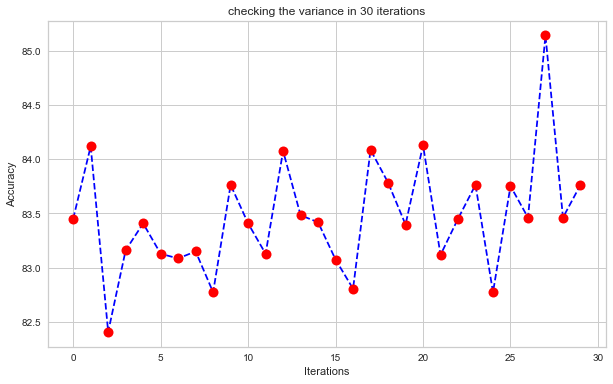

{'LG': [82.63082437275985,
  83.7708074631974,
  81.26438186849917,
  82.63082437275985,
  82.44399497049089,
  90.17732154344634,
  0.0022128009796142578],
 'Hypertuned': [82.90752688172043,
  84.2814171324002,
  80.93301422788635,
  82.90752688172043,
  82.68798169042311,
  90.70146389916543,
  0.0017877801259358727],
 'Pca': [83.34874551971329,
  84.49228597468674,
  82.48641889293559,
  83.34874551971329,
  83.24924577103879,
  91.1678835350506,
  0.0013912375768025717],
 'FImp': [83.46451612903226,
  84.47792872038376,
  82.17384279956295,
  83.46451612903226,
  83.33528048082484,
  89.5922995218501,
  0.001396318276723226]}

In [51]:

X = dataset[['cp','thall','oldpeak','caa','sex','thalachh','thall']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_LG['FImp'] = result
dict_LG

## Permutation Importance


In [52]:
#pip install eli5

In [53]:
import eli5
from eli5.sklearn import PermutationImportance
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
svc.fit(X_train, y_train) 
# create permutation importance object using model
# and fit on test set
perm = PermutationImportance(svc, random_state=1).fit(X_test, y_test)
  
# display weights using PermutationImportance object
eli5.show_weights(perm, feature_names =['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall'])

In [54]:


X = dataset[['caa','sex','oldpeak','cp','thalachh','exng','restecg','slp','thall']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_LG['Permutations'] = result
dict_LG


{'LG': [82.63082437275985,
  83.7708074631974,
  81.26438186849917,
  82.63082437275985,
  82.44399497049089,
  90.17732154344634,
  0.0022128009796142578],
 'Hypertuned': [82.90752688172043,
  84.2814171324002,
  80.93301422788635,
  82.90752688172043,
  82.68798169042311,
  90.70146389916543,
  0.0017877801259358727],
 'Pca': [83.34874551971329,
  84.49228597468674,
  82.48641889293559,
  83.34874551971329,
  83.24924577103879,
  91.1678835350506,
  0.0013912375768025717],
 'FImp': [83.46451612903226,
  84.47792872038376,
  82.17384279956295,
  83.46451612903226,
  83.33528048082484,
  89.5922995218501,
  0.001396318276723226],
 'Permutations': [83.4820788530466,
  84.69430426800477,
  82.04118826235162,
  83.4820788530466,
  83.35027337681863,
  90.39465976580449,
  0.0018266224861145021]}

## Sequential Forward Selection

In [55]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
sfs = SFS(svc, 
          k_features=8, 
          forward=True, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(1, 2, 4, 6, 7, 9, 11, 12)
('1', '2', '4', '6', '7', '9', '11', '12')
CV Score:
0.8422619047619048


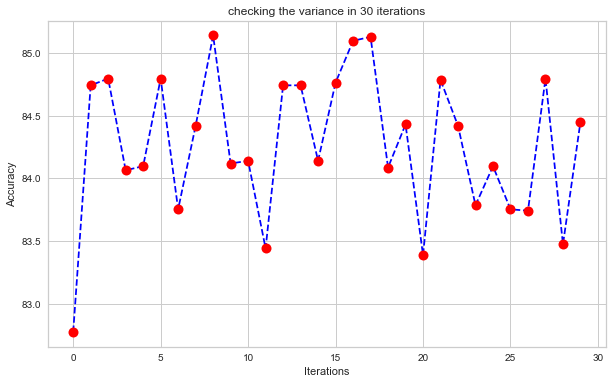

In [56]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_LG['SFS'] = result



In [57]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
sfs = SFS(svc, 
          k_features=8, 
          forward=False, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(1, 2, 3, 8, 9, 10, 11, 12)
('1', '2', '3', '8', '9', '10', '11', '12')
CV Score:
0.8381802721088436


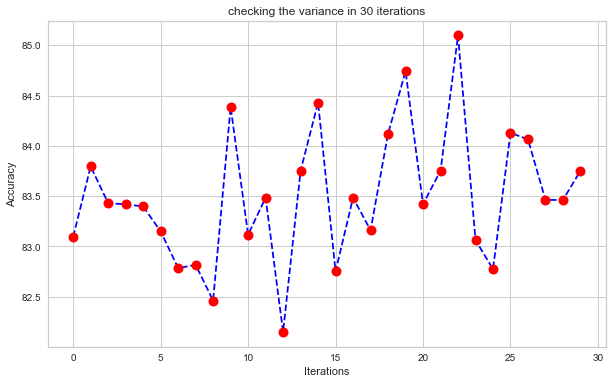

In [58]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_LG['SBS'] = result


## RFE


In [59]:
from sklearn.feature_selection import RFE
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
model=LogisticRegression()
rfe = RFE(model, n_features_to_select=8, step=1, verbose=2)
rfe = rfe.fit(X_train, y_train)
rfe.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


array([False,  True,  True,  True, False, False, False,  True,  True,
        True, False,  True,  True])

In [60]:
#'age sex cp trtbps chol fbs restecg thalachh exng oldpeak slp caa thall output'
X = dataset[['sex','cp','trtbps','thalachh','exng','oldpeak','caa','thall','slp']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_LG['RFE'] = result


## K-means

In [45]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
X = dataset.iloc[:, 0:-1].values
y_old = dataset.iloc[:, -1].values

scaled_features = standardise(X)


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(scaled_features)
visualizer.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(scaled_features)

In [25]:
y= kmeans.predict(scaled_features)

In [51]:
df = pd.DataFrame(scaled_features , columns= ['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall'])
#df['Cluster'] = y
#df['actual'] = y_old
df.head()

age       sex        cp    trtbps      chol       fbs   restecg  \
0  0.949794  0.682656  1.976470  0.764066 -0.261285  2.389793 -1.002541   
1 -1.928548  0.682656  1.005911 -0.091401  0.067741 -0.418446  0.901657   
2 -1.485726 -1.464866  0.035352 -0.091401 -0.822564 -0.418446 -1.002541   
3  0.174856  0.682656  0.035352 -0.661712 -0.203222 -0.418446  0.901657   
4  0.285561 -1.464866 -0.935208 -0.661712  2.080602 -0.418446  0.901657   

   thalachh      exng   oldpeak       slp       caa     thall  
0  0.018826 -0.698344  1.084022 -2.271182 -0.714911 -2.147955  
1  1.636979 -0.698344  2.118926 -2.271182 -0.714911 -0.513994  
2  0.980971 -0.698344  0.307844  0.979514 -0.714911 -0.513994  
3  1.243374 -0.698344 -0.209608  0.979514 -0.714911 -0.513994  
4  0.587366  1.431958 -0.382092  0.979514 -0.714911 -0.513994

In [66]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(scaled_features)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [67]:
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:-1],y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_LG['kmeans'] = result
result

[98.80752688172042,
 98.89904949813412,
 98.20596439885477,
 98.80752688172042,
 98.78948975940655,
 99.99840510366826,
 0.001422711213429769]

In [28]:
import shap
shap.initjs()

In [29]:
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

# compute SHAP values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)


[22:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
shap.plots.beeswarm(shap_values)

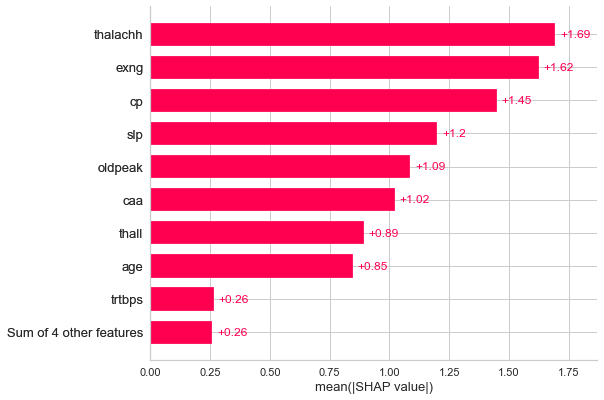

In [31]:
shap.plots.bar(shap_values)

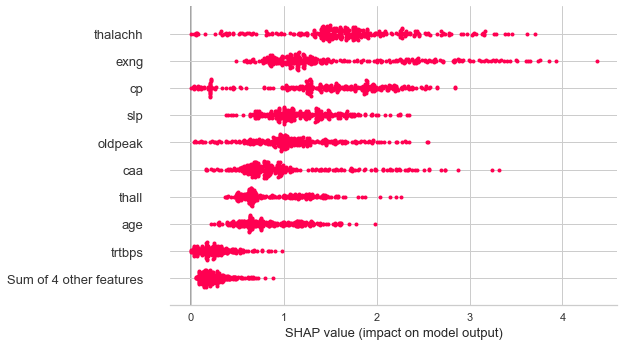

In [71]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

In [73]:
X = dataset[['caa','thalachh','oldpeak','cp','slp','exng','thall','age']].values
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_LG['kmeans+Shap'] = result

In [74]:
df_dict = pd.DataFrame.from_dict(dict_LG,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
LG            82.630824  83.770807    81.264382  82.630824  82.443995   
Hypertuned    82.907527  84.281417    80.933014  82.907527  82.687982   
Pca           83.348746  84.492286    82.486419  83.348746  83.249246   
FImp          83.464516  84.477929    82.173843  83.464516  83.335280   
Permutations  83.482079  84.694304    82.041188  83.482079  83.350273   
SFS           84.269892  85.407502    82.408064  84.269892  84.099182   
SBS           83.497133  84.497648    82.027083  83.497133  83.371895   
RFE           83.863799  85.057566    82.099479  83.863799  83.739721   
kmeans        98.807527  98.899049    98.205964  98.807527  98.789490   
kmeans+Shap   99.351254  99.389253    99.014351  99.351254  99.343522   

                    Roc  CPU_time  
LG            90.177322  0.002213  
Hypertuned    90.701464  0.001788  
Pca           91.167884  0.001391  
FImp          89.592300  0.001396  
Permutations  90.394660  0.001827  
SFS           90.017372  0.001278  
SBS           89.981045  0.001690  
RFE           90.881017  0.001882  
kmeans        99.998405  0.001423  
kmeans+Shap   99.988385  0.002257

In [75]:
#df_dict.to_excel('xl_result/LG_heart1_30.xlsx')

In [5]:
#df_dict =  pd.read_excel('xl_result/LG_heart1_30.xlsx',index_col=0)
#df_dict

In [4]:
# Adding Number of features
df_dict['no_of_features'] = [13,13,'4 components',7,9,8,8,8,13,8]
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
LG            82.630824  83.770807    81.264382  82.630824  82.443995   
Hypertuned    82.907527  84.281417    80.933014  82.907527  82.687982   
Pca           83.348746  84.492286    82.486419  83.348746  83.249246   
FImp          83.464516  84.477929    82.173843  83.464516  83.335280   
Permutations  83.482079  84.694304    82.041188  83.482079  83.350273   
SFS           84.269892  85.407502    82.408064  84.269892  84.099182   
SBS           83.497133  84.497648    82.027083  83.497133  83.371895   
RFE           83.863799  85.057566    82.099479  83.863799  83.739721   
kmeans        98.807527  98.899049    98.205964  98.807527  98.789490   
kmeans+Shap   99.351254  99.389253    99.014351  99.351254  99.343522   

                    Roc  CPU_time no_of_features  
LG            90.177322  0.002213             13  
Hypertuned    90.701464  0.001788             13  
Pca           91.167884  0.001391   4 components  
FImp          89.592300  0.001396              7  
Permutations  90.394660  0.001827              9  
SFS           90.017372  0.001278              8  
SBS           89.981045  0.001690              8  
RFE           90.881017  0.001882              8  
kmeans        99.998405  0.001423             13  
kmeans+Shap   99.988385  0.002257              8

## shap visualization  on 4 clusters 

In [68]:
def calculate_model_multi(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    cpu_10 = []
    roc_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        cpu = []
        roc_list = []
        



        for train_ix, test_ix in kfold.split(X, y):




            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            
            t0= time.time()
            if (param == 0):
                model = LogisticRegression()
                
            else:
                model = LogisticRegression(C=param['C'], penalty = param['penalty'])

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            #probs = model.predict_proba(X_test)
            #probs = probs[:, 1]
            t1 = time.time() - t0
                        #print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            #roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        #roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)

    plt.figure(figsize=(10,6))
    plt.plot(range(0,30),accuracy_10,color='blue', linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('checking the variance in 30 iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    #roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    return([accu,pre,spec,rec,f1,cpu])



In [46]:
X = dataset.iloc[:, 0:-1].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(scaled_features)
#y= kmeans.predict(scaled_features)

In [48]:
patient = pd.DataFrame(df.index)
cluster_no = pd.DataFrame(kmeans.labels_)
df_4= pd.DataFrame()
#Concatenating the patient ids with the assigned cluster lables
df_4 = pd.concat([patient,cluster_no], axis =1)
df_4.columns = ["patient", "cluster no"]

In [49]:
df_4

patient  cluster no
0          0           3
1          1           2
2          2           1
3          3           2
4          4           1
..       ...         ...
297      297           0
298      298           2
299      299           3
300      300           0
301      301           1

[302 rows x 2 columns]

In [52]:
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

[15:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred, index= df.index, columns = ["target"])
df_4 = df_4.set_index("patient")
cluster_df = pd.concat([df_4, y_pred], axis = 1)

In [54]:
cluster_df

cluster no  target
0             3       1
1             2       1
2             1       1
3             2       1
4             1       1
..          ...     ...
297           0       0
298           2       0
299           3       0
300           0       0
301           1       0

[302 rows x 2 columns]

In [55]:
group = (100 * cluster_df[cluster_df["target"]==1].groupby(by = ["cluster no","target"]).size()/len(df_4.index))
group = group.reset_index(level = 1, drop = True)
group = pd.DataFrame(group, columns  = ["Disease Percentage"])
group

Disease Percentage
cluster no                    
0                     2.980132
1                    20.198675
2                    23.841060
3                     7.284768

In [81]:
kmeans = KMeans(n_clusters=4,init='k-means++', random_state=0).fit(scaled_features)
y= kmeans.predict(scaled_features)

In [82]:
import shap
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

# compute SHAP values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)

[16:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [83]:
y

array([0, 3, 1, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 1, 3,
       1, 0, 3, 1, 0, 3, 0, 0, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 2, 1,
       3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 3, 1, 0, 1,
       3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 1, 0, 3, 3, 1, 3, 0, 1, 3, 3, 0,
       3, 2, 0, 1, 3, 0, 1, 2, 2, 0, 3, 0, 3, 3, 1, 0, 3, 3, 0, 2, 1, 1,
       2, 0, 3, 1, 1, 3, 3, 3, 1, 2, 2, 1, 3, 3, 3, 1, 1, 3, 3, 2, 3, 1,
       1, 1, 1, 1, 0, 0, 2, 2, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3,
       3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 0, 1, 3, 3, 2, 2, 0,
       3, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 3, 0, 2,
       1, 1, 2, 2, 0, 2, 1, 2, 2, 3, 1, 3, 2, 1, 2, 0, 2, 3, 0, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2,
       2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 1, 0, 2, 2, 0, 0, 1, 2, 2, 3,
       1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 0, 2, 3, 0, 2,

In [84]:
shap.summary_plot(shap_values[:,:,2], df)

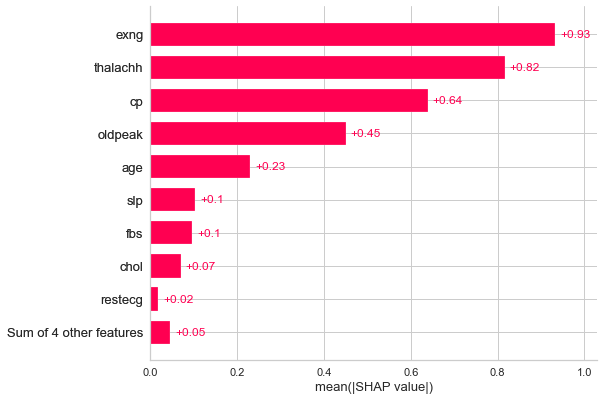

In [113]:
shap.plots.bar(shap_values[:,:,2])

In [66]:
dict_LG['Kmeans_2_clusters'] = [98.80752688172042,
 98.89904949813412,
 98.20596439885477,
 98.80752688172042,
 98.78948975940655,

 0.001422711213429769]

In [88]:
y

array([0, 3, 1, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 1, 3,
       1, 0, 3, 1, 0, 3, 0, 0, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 2, 1,
       3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 3, 1, 0, 1,
       3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 1, 0, 3, 3, 1, 3, 0, 1, 3, 3, 0,
       3, 2, 0, 1, 3, 0, 1, 2, 2, 0, 3, 0, 3, 3, 1, 0, 3, 3, 0, 2, 1, 1,
       2, 0, 3, 1, 1, 3, 3, 3, 1, 2, 2, 1, 3, 3, 3, 1, 1, 3, 3, 2, 3, 1,
       1, 1, 1, 1, 0, 0, 2, 2, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3,
       3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 0, 1, 3, 3, 2, 2, 0,
       3, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 3, 0, 2,
       1, 1, 2, 2, 0, 2, 1, 2, 2, 3, 1, 3, 2, 1, 2, 0, 2, 3, 0, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2,
       2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 1, 0, 2, 2, 0, 0, 1, 2, 2, 3,
       1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 0, 2, 3, 0, 2,

In [89]:
X=scaled_features  
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()

#print(param)

result = calculate_model_multi(param,X,y)
result

[97.4921146953405,
 97.86202437447061,
 100.0,
 97.4921146953405,
 97.5031358417012,
 0.008192392190297446]

In [90]:
dict_LG['Kmeans_ideal_clusters'] = result

In [107]:
X = dataset[['thalachh','oldpeak','slp','age','fbs','chol','cp','restecg','exng']].values
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model_multi(param,X,y)
result
dict_LG['kmeans_ideal_clusters+Shap'] = result

In [110]:
dict_LG

{'Kmeans_2_clusters': [98.80752688172042,
  98.89904949813412,
  98.20596439885477,
  98.80752688172042,
  98.78948975940655,
  0.001422711213429769],
 'Kmeans_ideal_clusters': [97.4921146953405,
  97.86202437447061,
  100.0,
  97.4921146953405,
  97.5031358417012,
  0.008192392190297446],
 'kmeans_ideal_clusters+Shap': [98.43261648745516,
  98.65474894728928,
  100.0,
  98.43261648745516,
  98.44107284677722,
  0.003287831942240398]}

In [111]:
df_dict = pd.DataFrame.from_dict(dict_LG,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','CPU_time'])
df_dict

Accuracy  Precision  Specificity     Recall  \
Kmeans_2_clusters           98.807527  98.899049    98.205964  98.807527   
Kmeans_ideal_clusters       97.492115  97.862024   100.000000  97.492115   
kmeans_ideal_clusters+Shap  98.432616  98.654749   100.000000  98.432616   

                             F1_score  CPU_time  
Kmeans_2_clusters           98.789490  0.001423  
Kmeans_ideal_clusters       97.503136  0.008192  
kmeans_ideal_clusters+Shap  98.441073  0.003288

In [112]:
# Adding Number of features
df_dict['no_of_features'] = [13,13,9]
df_dict

Accuracy  Precision  Specificity     Recall  \
Kmeans_2_clusters           98.807527  98.899049    98.205964  98.807527   
Kmeans_ideal_clusters       97.492115  97.862024   100.000000  97.492115   
kmeans_ideal_clusters+Shap  98.432616  98.654749   100.000000  98.432616   

                             F1_score  CPU_time  no_of_features  
Kmeans_2_clusters           98.789490  0.001423              13  
Kmeans_ideal_clusters       97.503136  0.008192              13  
kmeans_ideal_clusters+Shap  98.441073  0.003288               9